## Dependências

In [40]:
# Checagem/instalação leve de dependências
print("Verificando dependências (pyarrow para Parquet)...")

try:
    import pyarrow as pa
    print(f"PyArrow disponível: {pa.__version__}")
except Exception:
    print("Instalando pyarrow...")
    !pip install --upgrade "pyarrow>=18" --quiet
    import importlib
    importlib.invalidate_caches()
    import pyarrow as pa
    print(f"PyArrow instalado: {pa.__version__}")

# fastparquet é opcional
try:
    import fastparquet  # noqa: F401
    print("fastparquet disponível (opcional)")
except Exception:
    pass

# Outras bibliotecas sob demanda
for lib in [
    "numpy", "python-dotenv", "pandas", "matplotlib", "seaborn",
    "scikit-learn", "tensorflow", "keras", "lxml", "pytz", "requests", "optuna"
]:
    try:
        __import__(lib)
    except ImportError:
        print(f"Instalando {lib}...")
        !pip install {lib} --quiet

print("Dependências prontas")

Verificando dependências (pyarrow para Parquet)...
PyArrow disponível: 21.0.0
Instalando python-dotenv...
Instalando scikit-learn...



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Instalando optuna...



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Dependências prontas



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Imports

In [38]:
# Imports para a API e utilidades
import os
import requests
import pandas
from dotenv import load_dotenv
from datetime import datetime, timedelta, date
import pytz
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Carregar variáveis de ambiente do .env
load_dotenv()

True

### Notas de Otimização e Uso

Esta versão do fluxo de coleta recebeu melhorias focadas em desempenho e reprodutibilidade e foi ajustada para:

1. Sessão HTTP reutilizada com pool e retries para reduzir overhead de conexão e lidar com erros transitórios (429 / 5xx).
2. Chunking automático de janelas longas (`CHUNK_DAYS`) evitando limites práticos da API e permitindo montar períodos maiores via concatenação.
3. Parsing XML mais rápido via `lxml.iterparse` com fallback para `pandas.read_xml`.
4. Dtypes otimizados (`float32`, `Int32`, `category`) diminuindo memória e tamanho de arquivos Parquet.
5. Salvamento Parquet com compressão configurável (`PARQUET_COMPRESSION` = `zstd` por padrão). Ajuste para `snappy` se priorizar velocidade de leitura.
6. Overwrite forçado (`ALWAYS_OVERWRITE=True`) — sempre reescreve os Parquet.
7. Leitura "lazy" nas visualizações (seleção de colunas) para diminuir tempo e uso de RAM.
8. Construção de parâmetros usando apenas valores não nulos; evita requisições inválidas.
9. Frequência padronizada em 15 minutos, iniciando à meia‑noite do dia (96 pontos/dia) para carga e preço.

Variáveis importantes
- `MAX_WORKERS`: ajuste se receber muitos 429; valores entre 4 e 8 costumam ser seguros.
- `CHUNK_DAYS`: use 30 para segurança. Reduza se notar timeouts; aumente apenas se a API aceitar.
- `PARQUET_COMPRESSION`: `zstd` (boa razão de compressão) ou `snappy` (mais rápido, maior tamanho).
- `DATE_RANGES`: fixado em 365 dias (até ontem) conforme solicitado.

Reexecuções
1. Execute as células na ordem: dependências → imports → funções utilitárias → configuração → coleta → visualização → builders (Etapa 2).
2. Verifique se o token está definido.

Token ENTSO‑E
Crie um arquivo `.env` com:
```
ENTSOE_SECURITY_TOKEN=SEU_TOKEN_AQUI
```

Próximos passos sugeridos
- Adicionar sanity checks: validar 96 pontos por dia por arquivo.
- Acrescentar stubs de treino/avaliação para Linear/LSTM/TFT/TimesFM usando os builders L1/L2/L3.
- Implementar cache opcional do XML bruto para debug.

# Etapa 2: Préprocessamento de dados

Etapa de contrução da pipelines de pre-processamento de dados

Cada modelo terá uma classe específica criada especificamente para poder préprocessar seus dados para cada um dos problemas a serem resulvidos em suas respectivas etapas

As classe vai incluir métodos de:

- Encodding
- Decodding
- Normalization
- Denormalization

Ao final do processamento de dados os arquivos será salvos na pasta:

_./data/processed/{model_name}/_


Essa etapa será dividida em 4 capitulos:

1. Linear
2. LSTM
3. TFT
4. Times FM

## Capitulo 0: Classe geral de preprocessamento

In [45]:
import os
from typing import Optional, List
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
import numpy as np
import time

class Preprocessor:
    """Pré-processador base.

    - lag/lead como inteiros são expandidos para ranges [1..N] quando apropriado.
    - feature_cols/target_cols definem bases permitidas e servem como seleção no export.
    - Nenhuma coluna é removida dos dados; seleção ocorre apenas na exportação.
    """
    def __init__(
        self,
        lag: int,
        lead: int,
        country_list: Optional[List[str]] = None,
        *,
        model_name: str = "linear",
        data_dir: str = "data/processed",
        feature_cols: Optional[List[str]] = None,
        target_cols: Optional[List[str]] = None,
    ):
        self.lag = lag
        self.lead = lead
        self.country_list = country_list
        self.model_name = model_name
        self.data_dir = data_dir
        self.save_dir = os.path.join(self.data_dir, self.model_name)
        os.makedirs(self.save_dir, exist_ok=True)

        self.feature_cols: List[str] = list(feature_cols) if feature_cols else []
        self.target_cols: List[str] = list(target_cols) if target_cols else []

        self.norm_objects = {}
        self.encod_objects = {}
        self.df_base = pd.DataFrame()

    def _expand_steps(self, steps, default_max: Optional[int]) -> List[int]:
        """Normaliza passos: int→[1..N], None→[1..default_max], lista→como está."""
        if isinstance(steps, int):
            return list(range(1, steps + 1)) if steps > 0 else [1]
        if steps is None and isinstance(default_max, int) and default_max > 0:
            return list(range(1, default_max + 1))
        if isinstance(steps, (list, tuple)):
            return list(steps)
        return [1]

    def load_data(self, raw_dir: Optional[str] = None) -> pd.DataFrame:
        """Carrega Parquet unificado em data/raw (ou raw_dir) e atualiza self.df_base."""
        base_raw = raw_dir or os.path.join('data', 'raw')
        unified_path = os.path.join(base_raw, f'raw_dataset.parquet')
        if not os.path.exists(unified_path):
            raise FileNotFoundError(f"Arquivo unificado não encontrado: {unified_path}. Execute a coleta primeiro.")
        df = pd.read_parquet(unified_path, engine='pyarrow')
        if 'datetime' in df.columns:
            df['datetime'] = pd.to_datetime(df['datetime'], utc=True)
        if self.country_list and 'country' in df.columns:
            df = df[df['country'].isin(self.country_list)].copy()
        sort_cols = [c for c in ['country', 'datetime'] if c in df.columns]
        if sort_cols:
            df = df.sort_values(sort_cols).reset_index(drop=True)
            
        # Filtrando Colunas apenas para as necessárias
        cols = list(set([c for c in self.feature_cols + self.target_cols if c in df.columns]))
        df = df.loc[:, ~df.columns.duplicated()]  # optional: remove duplicates
        df = df[cols]

        self.df_base = df
        return self.df_base

    def encode(self, encode_cols: str = 'datetime', encode_method: str = 'label') -> pd.DataFrame:
        """Codifica de forma não destrutiva e atualiza self.df_base.

        - label: usa LabelEncoder com suporte a NaN via placeholder interno que é revertido no decode.
        - time_cycle: adiciona features de calendário e cíclicas sem remover datetime.
        """
        if self.df_base is None or self.df_base.empty:
            print("df_base vazio. Chame load_data() primeiro.")
            return self.df_base
        df = self.df_base.copy()
        if encode_method == 'label':
            le = LabelEncoder()
            s = df[encode_cols].astype(object)
            le.fit(s)
            df[encode_cols] = le.transform(s)
            # salva metadados incluindo o code do NaN
            self.encod_objects['label'] = {
                'encode_cols': encode_cols,
                'label_encoder': le,
            }
        elif encode_method == 'time_cycle':
            if encode_cols not in df.columns:
                print(f"Coluna {encode_cols} não encontrada para time_cycle.")
                self.df_base = df
                return df
            dt = pd.to_datetime(df[encode_cols], utc=True)
            # Mantém a coluna original e adiciona componentes discretos e cíclicos
            df['year'] = dt.dt.year
            df['month'] = dt.dt.month
            df['day'] = dt.dt.day
            df['hour'] = dt.dt.hour
            df['minute'] = dt.dt.minute
            current_year = time.localtime().tm_year
            df['year_sin'] = np.sin(2 * np.pi * df['year'] / max(current_year, 1))
            df['year_cos'] = np.cos(2 * np.pi * df['year'] / max(current_year, 1))
            df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
            df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
            df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
            df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
            df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
            df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
            df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
            df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)
            self.encod_objects['time_cycle'] = {'encode_cols': encode_cols}
        else:
            print(f"encode_method '{encode_method}' não suportado.")
        self.df_base = df
        self.feature_cols.extend(["year_sin", "year_cos",
                                                     "month_sin", "month_cos",
                                                     "day_sin", "day_cos",
                                                     "hour_sin", "hour_cos",
                                                     "minute_sin", "minute_cos"])
        return self.df_base

    def decode(self, encode_method: str = 'label', target_col: Optional[str] = None) -> pd.DataFrame:
        """Reverte codificações suportadas (label, time_cycle)."""
        if self.df_base is None or self.df_base.empty:
            print("df_base vazio. Nada para decodificar.")
            return self.df_base
        df = self.df_base.copy()
        if encode_method == 'label':
            info = self.encod_objects.get('label')
            if not info:
                print("Nenhuma informação de label encoding salva.")
                return self.df_base
            col = info['encode_cols']
            le: LabelEncoder = info['label_encoder']
            placeholder = info.get('na_placeholder', '__NA__')
            try:
                inv = le.inverse_transform(df[col].astype(int))
                # mapeia placeholder de volta para NaN
                inv = pd.Series(inv).replace(placeholder, np.nan).values
                df[col] = inv
            except Exception as e:
                print(f"Falha ao decodificar label para coluna {col}: {e}")
        elif encode_method == 'time_cycle':
            if 'year' not in df.columns:
                print("Componentes de tempo ausentes para reconstrução.")
                return self.df_base
            tgt = target_col or 'decoded_datetime'
            def _recover_component(sin_col, cos_col, period, offset):
                if sin_col not in df.columns or cos_col not in df.columns:
                    return pd.Series([np.nan] * len(df))
                ang = np.arctan2(df[sin_col], df[cos_col])
                ang = (ang + 2 * np.pi) % (2 * np.pi)
                idx = np.round((ang / (2 * np.pi)) * period).astype('Int64') % period
                return idx + offset
            month = _recover_component('month_sin', 'month_cos', 12, 1)
            day = _recover_component('day_sin', 'day_cos', 31, 1)
            hour = _recover_component('hour_sin', 'hour_cos', 24, 0)
            minute = _recover_component('minute_sin', 'minute_cos', 60, 0)
            year = df['year'] if 'year' in df.columns else pd.Series([np.nan] * len(df))
            dt = pd.to_datetime({
                'year': year.astype('Int64'),
                'month': month.astype('Int64'),
                'day': day.astype('Int64'),
                'hour': hour.astype('Int64'),
                'minute': minute.astype('Int64'),
            }, errors='coerce', utc=True)
            df[tgt] = dt
        else:
            print(f"encode_method '{encode_method}' não suportado para decode.")
        self.df_base = df
        return self.df_base

    def normalize(self, value_cols: List[str], normalization_method: str = 'minmax') -> pd.DataFrame:
        """Normaliza colunas e atualiza self.df_base."""
        if self.df_base is None or self.df_base.empty:
            print("df_base vazio. Chame load_data() primeiro.")
            return self.df_base
        df = self.df_base.copy()
        scaler = MinMaxScaler() if normalization_method == 'minmax' else (
            StandardScaler() if normalization_method == 'standard' else None)
        if scaler is None:
            raise ValueError("normalization_method deve ser 'minmax' ou 'standard'")
        df[value_cols] = scaler.fit_transform(df[value_cols])
        self.norm_objects[normalization_method] = {'value_cols': value_cols, 'scaler': scaler}
        self.df_base = df
        return self.df_base

    def normalize_splits(self, value_cols: List[str], normalization_method: str = 'minmax') -> dict:
        """Normaliza os conjuntos de treino, validação e teste."""
        if not self.splits:
            print("Nenhum conjunto dividido encontrado.")
            return {}
        normalized_splits = {}
        for split_name, split_df in self.splits.items():
            self.df_base = split_df
            normalized_df = self.normalize(value_cols=value_cols, normalization_method=normalization_method)
            normalized_splits[split_name] = normalized_df
        self.splits = normalized_splits
        return normalized_splits

    def denormalize(self, normalization_method: str = 'minmax') -> pd.DataFrame:
        """Reverte normalização usando metadados salvos."""
        if self.df_base is None or self.df_base.empty:
            print("df_base vazio. Nada para denormalizar.")
            return self.df_base
        info = self.norm_objects.get(normalization_method)
        if not info:
            print(f"Nenhum scaler salvo para o método '{normalization_method}'.")
            return self.df_base
        cols: List[str] = info['value_cols']
        scaler = info['scaler']
        df = self.df_base.copy()
        try:
            df[cols] = scaler.inverse_transform(df[cols])
        except Exception as e:
            print(f"Falha ao denormalizar colunas {cols}: {e}")
            return self.df_base
        self.df_base = df
        return self.df_base

    def save_df_base(self, filename: Optional[str] = None, compression: Optional[str] = None, partition_by: Optional[List[str]] = None) -> Optional[str]:
        """Salva self.df_base em Parquet dentro de data_dir/{model_name}."""
        if self.df_base is None or self.df_base.empty:
            print("df_base vazio. Nada para salvar.")
            return None
        comp = compression
        if comp is None:
            try:
                comp = PARQUET_COMPRESSION
            except NameError:
                comp = 'zstd'
        filename = "raw_dataset.parquet"
        out_path = os.path.join(self.save_dir, filename)
        df = self.df_base.copy()
        if 'datetime' in df.columns:
            df['datetime'] = pd.to_datetime(df['datetime'], utc=True)
        try:
            if partition_by:
                df.to_parquet(out_path, engine='pyarrow', compression=comp, index=False, partition_cols=partition_by)
            else:
                df.to_parquet(out_path, engine='pyarrow', compression=comp, index=False)
            print(f"[SALVO] df_base: {len(df):,} linhas → {out_path}")
            return out_path
        except Exception as e:
            print(f"Falha ao salvar df_base em {out_path}: {e}")
            return None
    
    def split_train_val_test(self, train_size: float = 0.7, val_size: float = 0.15, test_size: float = 0.15, time_col: str = 'datetime') -> Optional[dict]:
        """Divide df_base em conjuntos de treino, validação e teste com base em time_col."""
        if self.df_base is None or self.df_base.empty:
            print("df_base vazio. Nada para dividir.")
            return None
        if not np.isclose(train_size + val_size + test_size, 1.0):
            print("train_size, val_size e test_size devem somar 1.0")
            return None
        df = self.df_base.copy()
        if time_col not in df.columns:
            print(f"Coluna de tempo '{time_col}' não encontrada em df_base.")
            return None
        df = df.sort_values(time_col).reset_index(drop=True)
        n = len(df)
        train_end = int(n * train_size)
        val_end = train_end + int(n * val_size)
        splits = {
            'train': df.iloc[:train_end].reset_index(drop=True),
            'val': df.iloc[train_end:val_end].reset_index(drop=True),
            'test': df.iloc[val_end:].reset_index(drop=True),
        }
        for split_name, split_df in splits.items():
            print(f"[DIVIDIDO] {split_name}: {len(split_df):,} linhas")
        self.splits = splits
        return splits

## Capítulo 1: Preprocessamento do Modelo Linear

Esse modelo deve será contruido a partir de lags e leads passados como parâmetros na função, resultando na contrução de novas colunas lead lag, assim gerando uma flat matrix 2D que será usada no modelo linear

Observação importante: lag e lead são inteiros e representam o máximo de passos; o pipeline expande para intervalos 1..N automaticamente. Por exemplo, lag=96 gera features com defasagens de 1 a 96; lead=96 gera alvos de 1 a 96.

Os arquivos do modelo serão salvos em TFrecords já que o modelo linear será contruído usando tensor flow

In [46]:
class LinearPreprocessor(Preprocessor):
    """Pré-processador linear: gera matriz flat (lags/leads) e exporta TFRecords.

    Princípios:
    - Não remove colunas do df_base, apenas adiciona as derivadas.
    - Usa feature_cols/target_cols definidos no construtor do Preprocessor.
    - Seleção é estrita apenas na exportação (TFRecords).
    """

    def build_flat_matrix(
        self,
        value_cols: Optional[List[str]] = None,
        target_cols: Optional[List[str]] = None,
        lags: Optional[int] = None,
        leads: Optional[int] = None,
        dropna: bool = True,
        group_cols: Optional[List[str]] = None,
        time_col: str = "datetime",
    ) -> pd.DataFrame:
        if self.df_base is None or self.df_base.empty:
            print("df_base vazio. Chame load_data() primeiro.")
            return self.df_base

        df = self.df_base.copy()
        feats = value_cols or self.feature_cols
        tgts = target_cols or self.target_cols
        if not feats:
            raise ValueError("Nenhuma coluna de feature informada.")
        if not tgts:
            raise ValueError("Nenhum target informado.")

        group_cols = group_cols or [c for c in ["country"] if c in df.columns]

        # Ensure time_col exists
        if time_col not in df.columns:
            raise ValueError(f"Coluna temporal '{time_col}' não encontrada no DataFrame.")

        # Sorting by group and time (MUST BE DONE)
        sort_cols = (group_cols or []) + [time_col]
        df = df.sort_values(sort_cols).reset_index(drop=True)

        # Make sure time order is preserved
        if group_cols:
            df["_group_id"] = df[group_cols].astype(str).agg("_".join, axis=1)
        else:
            df["_group_id"] = "global"

        lag_steps = list(range(1, (lags or self.lag or 0) + 1))
        lead_steps = list(range(1, (leads or self.lead or 0) + 1))

        new_cols = []

        # ---- Lags ----
        for col in feats:
            if col not in df.columns:
                print(f"[WARN] Coluna de feature '{col}' não encontrada.")
                continue
            for k in lag_steps:
                cname = f"{col}_lag{k}"
                df[cname] = (
                    df.groupby("_group_id", group_keys=False, sort=False)[col].shift(k)
                )
                new_cols.append(cname)

        # ---- Leads ----
        for tgt in tgts:
            if tgt in df.columns:
                for k in lead_steps:
                    cname = f"{tgt}_lead{k}"
                    df[cname] = (
                        df.groupby("_group_id", group_keys=False, sort=False)[tgt].shift(-k)
                    )
                    new_cols.append(cname)
            else:
                print(f"[WARN] Target '{tgt}' não encontrado. Ignorando leads.")

        # Drop rows that don't have all required lags/leads
        if dropna and new_cols:
            df = df.dropna(subset=new_cols).reset_index(drop=True)

        # Clean temp columns
        df.drop(columns=["_group_id"], inplace=True, errors="ignore")

        self.df_base = df

        #adiciona novas colunas automaticamente
        self.feature_cols.extend([c for c in new_cols if "_lag" in c])
        self.target_cols.extend([c for c in new_cols if "_lead" in c])
        return self.df_base

    def build_flat_matrices_splits(
        self,
        value_cols: Optional[List[str]] = None,
        target_cols: Optional[List[str]] = None,
        lags: Optional[int] = None,
        leads: Optional[int] = None,
        dropna: bool = True,
        group_cols: Optional[List[str]] = None,
        time_col: str = "datetime",
    ) -> Optional[dict]:
        """Constrói matrizes flat para cada split (train/val/test)."""
        if not self.splits:
            print("Nenhum conjunto dividido encontrado.")
            return None
        built_splits = {}
        for split_name, split_df in self.splits.items():
            self.df_base = split_df
            built_df = self.build_flat_matrix(
                value_cols=value_cols,
                target_cols=target_cols,
                lags=lags,
                leads=leads,
                dropna=dropna,
                group_cols=group_cols,
                time_col=time_col,
            )
            built_splits[split_name] = built_df
        self.splits = built_splits
        return built_splits
    def save_tfrecords(
        self,
        output_basename: str = 'dataset',
        shard_size: int = 100_000,
        compression: Optional[str] = None,
    ) -> Optional[List[str]]:
        if self.df_base is None or self.df_base.empty:
            print("df_base vazio. Nada para salvar em TFRecords.")
            return None
        try:
            import tensorflow as tf
        except Exception as e:
            print(f"TensorFlow não disponível: {e}")
            return None

        # Seleção estrita: apenas colunas configuradas e existentes
        # Seleção estrita + apenas colunas numéricas
        numeric_cols = self.df_base.select_dtypes(include=["number", "bool"]).columns
        present_feats = [c for c in self.feature_cols if c in numeric_cols]
        present_tgts = [c for c in self.target_cols if c in numeric_cols]
        self.feature_cols = present_feats
        self.target_cols = present_tgts
        if not present_feats:
            print("Nenhuma feature presente no df_base para export.")
            return None
        if not present_tgts:
            print("Nenhum target presente no df_base para export.")
            return None

        missing_feats = [c for c in self.feature_cols if c not in present_feats]
        missing_tgts = [c for c in self.target_cols if c not in present_tgts]
        if missing_feats:
            print(f"[WARN] Features ausentes: {missing_feats}")
        if missing_tgts:
            print(f"[WARN] Targets ausentes: {missing_tgts}")

        df = self.df_base.reset_index(drop=True)
        X = df[present_feats].astype('float32').to_numpy(copy=False)
        y = df[present_tgts].astype('float32').to_numpy(copy=False)

        x_dim = X.shape[1]
        y_dim = y.shape[1]
        n = len(df)

        def _float_feature(v):
            return tf.train.Feature(float_list=tf.train.FloatList(value=v))

        def _serialize_row(i):
            example = tf.train.Example(features=tf.train.Features(feature={
                'x': _float_feature(X[i]),
                'y': _float_feature(y[i]),
            }))
            return example.SerializeToString()

        comp = compression or 'GZIP'
        options = tf.io.TFRecordOptions(compression_type=comp) if comp else None

        paths: List[str] = []
        for shard_idx, start in enumerate(range(0, n, shard_size)):
            end = min(start + shard_size, n)
            shard_path = os.path.join(self.save_dir, f"{output_basename}_{shard_idx}.tfrecord")
            with tf.io.TFRecordWriter(shard_path, options=options) as w:
                for i in range(start, end):
                    w.write(_serialize_row(i))
            paths.append(shard_path)

        # Metadados
        meta = {
            'x_dim': int(x_dim),
            'y_dim': int(y_dim),
            'feature_cols': present_feats,
            'target_cols': present_tgts,
            'count': int(n),
            'compression': comp or 'NONE',
            'basename': output_basename,
        }
        try:
            import json
            with open(os.path.join(self.save_dir, f"{output_basename}.meta.json"), 'w', encoding='utf-8') as f:
                json.dump(meta, f, ensure_ascii=False, indent=2)
        except Exception as e:
            print(f"[WARN] Falha ao salvar metadados: {e}")

        print(f"[SALVO] TFRecords: {len(paths)} shard(s) em {self.save_dir}")
        return paths
    
    def save_splits_tfrecords(
        self,
        output_basename: str = 'dataset',
        shard_size: int = 100_000,
        compression: Optional[str] = None,
    ) -> Optional[dict]:
        """Salva TFRecords para cada split (train/val/test)."""
        if not self.splits:
            print("Nenhum conjunto dividido encontrado.")
            return None
        paths_dict = {}
        for split_name, split_df in self.splits.items():
            self.df_base = split_df
            paths = self.save_tfrecords(
                output_basename=f"{output_basename}_{split_name}",
                shard_size=shard_size,
                compression=compression,
            )
            paths_dict[split_name] = paths
        return paths_dict

# Capítulo 3 — Construção dos Modelos

A seguir, definimos construtores simples e eficientes para cada modelo (Linear, LSTM, TFT e TimesFM),
prontos para uso em rotinas de otimização de hiperparâmetros (por exemplo, Optuna). Cada construtor
recebe um dicionário de parâmetros (`params`) e retorna um modelo compilado.

## Construção do Modelo Linear

Objetivo: um regressor denso simples (MLP) para prever `target_cols` a partir de `feature_cols`.

Contrato rápido:
- Entrada: vetor de tamanho `x_dim` (número de features)
- Saída: vetor de tamanho `y_dim` (número de targets)
- Parâmetros (exemplos): hidden_units, activation, dropout, lr, l2

In [50]:
from typing import Dict, Any
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


def build_linear_model(x_dim: int, y_dim: int, params: Dict[str, Any]) -> keras.Model:
    """Constrói um MLP simples para regressão multivariada.

    params:
      - hidden_units: List[int]
      - activation: str (ex.: 'relu')
      - dropout: float (0..1)
      - l2: float (regularização L2)
      - lr: float (learning rate)
    """
    hidden_units = params.get('hidden_units', [128, 64])
    activation = params.get('activation', 'relu')
    dropout = float(params.get('dropout', 0.0))
    l2 = float(params.get('l2', 0.0))
    lr = float(params.get('lr', 1e-3))

    inputs = keras.Input(shape=(x_dim,), name='features')
    x = inputs
    for i, units in enumerate(hidden_units):
        x = layers.Dense(units, activation=activation,
                         kernel_regularizer=keras.regularizers.l2(l2),
                         name=f'dense_{i}')(x)
        if dropout > 0:
            x = layers.Dropout(dropout, name=f'dropout_{i}')(x)
    outputs = layers.Dense(y_dim, name='targets')(x)

    model = keras.Model(inputs, outputs, name='linear_mlp')
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss='mse', metrics=['mae'])
    return model

# Funções auxiliares para carregar TFRecords
def parse_tfrecord(example_proto, x_dim, y_dim):
    feature_description = {
        'x': tf.io.VarLenFeature(tf.float32),
        'y': tf.io.VarLenFeature(tf.float32),
    }
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    x = tf.sparse.to_dense(parsed['x'])
    y = tf.sparse.to_dense(parsed['y'])
    x = tf.reshape(x, [x_dim])
    y = tf.reshape(y, [y_dim])
    return x, y

def load_tfrecord_dataset(path_pattern, x_dim, y_dim, batch_size=64, compression='GZIP'):
    files = tf.io.gfile.glob(path_pattern)
    ds = tf.data.TFRecordDataset(files, compression_type=compression)
    ds = ds.map(lambda x: parse_tfrecord(x, x_dim, y_dim),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# Capítulo 4 - Contrução da Pipelines de dados dos modelos

Contruir o fluxo de dados, incluindo a o preprocessamento e treinamento dos modelos

## Pipeline dos Modelos Lineares

Será gerada uma pipeline completa para cada nível de pergunta

Cada função irá processar os dados para cad problema e fazer o treinamento do modelo

Seus outputs serão os modelos treinados, onde os valores serão comparados ao final do modelo

In [53]:
import optuna
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def linear_pipeline(
    data_dir: str,
    country_list: List[str],
    feature_cols: List[str],
    target_cols: List[str],
    lag: int,
    lead: int,
    value_cols: List[str],
    use_optuna: bool = True,
    n_trials: int = 20
) -> Tuple[LinearPreprocessor, keras.Model]:
    
    # ----------------------------
    # Pré-processamento
    # ----------------------------
    preproc = LinearPreprocessor(
        data_dir=data_dir,
        model_name='linear_model',
        feature_cols=feature_cols,
        target_cols=target_cols,
        lag=lag,
        lead=lead,
        country_list=country_list
    )
    
    preproc.load_data()
    preproc.encode(encode_cols='datetime', encode_method='time_cycle')
    preproc.encode(encode_cols='country', encode_method='label')
    preproc.split_train_val_test(train_size=0.6, val_size=0.2, test_size=0.2, time_col='datetime')
    preproc.normalize_splits(value_cols=value_cols, normalization_method='minmax')
    preproc.build_flat_matrices_splits(
        value_cols=value_cols,
        target_cols=target_cols,
        dropna=True,
        group_cols=['country'],
        time_col='datetime'
    )
    preproc.save_splits_tfrecords(output_basename='linear_dataset', shard_size=50000, compression='GZIP')
    print("Pré-processamento linear concluído.")

    # ----------------------------
    # TFRecord datasets
    # ----------------------------
    x_dim = len(preproc.feature_cols)
    y_dim = len(preproc.target_cols)

    dataset_train = load_tfrecord_dataset(
        path_pattern=os.path.join(preproc.save_dir, 'linear_dataset_train*.tfrecord'),
        x_dim=x_dim, y_dim=y_dim, batch_size=64
    )
    dataset_val = load_tfrecord_dataset(
        path_pattern=os.path.join(preproc.save_dir, 'linear_dataset_val*.tfrecord'),
        x_dim=x_dim, y_dim=y_dim, batch_size=64
    )
    print("Dataset TFRecord carregado para treinamento.")

    # ----------------------------
    # Optuna hyperparameter search
    # ----------------------------
    if use_optuna:
        def objective(trial):
            # Hyperparameters
            hidden_layers = trial.suggest_int("n_layers", 1, 3)
            hidden_units = [trial.suggest_int(f"units_l{i}", 32, 512, step=32) for i in range(hidden_layers)]
            activation = trial.suggest_categorical("activation", ["relu", "tanh", "leaky_relu"])
            dropout = trial.suggest_float("dropout", 0.0, 0.3)
            l2 = trial.suggest_float("l2", 1e-6, 1e-3, log=True)
            lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

            params = {
                "hidden_units": hidden_units,
                "activation": activation,
                "dropout": dropout,
                "l2": l2,
                "lr": lr
            }

            model = build_linear_model(x_dim=x_dim, y_dim=y_dim, params=params)

            # Callbacks
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

            history = model.fit(
                dataset_train,
                validation_data=dataset_val,
                epochs=50,
                callbacks=[early_stopping],
                verbose=0
            )
            return min(history.history['val_loss'])

        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=n_trials, n_jobs=5)
        print("Melhores hiperparâmetros Optuna:", study.best_params)

        # Reconstruir modelo final com melhores hiperparâmetros
        best_params = study.best_params
        hidden_layers = best_params.pop("n_layers")
        hidden_units = [best_params.pop(f"units_l{i}") for i in range(hidden_layers)]
        best_params["hidden_units"] = hidden_units
    else:
        # Valores default
        best_params = {'hidden_units':[128,64], 'activation':'relu', 'dropout':0.1, 'l2':1e-6, 'lr':1e-3}

    # ----------------------------
    # Construção do modelo final
    # ----------------------------
    model = build_linear_model(x_dim=x_dim, y_dim=y_dim, params=best_params)

    # Callbacks finais
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

    model.fit(dataset_train, validation_data=dataset_val, epochs=100, callbacks=[early_stopping, reduce_lr])

    # ----------------------------
    # Plot histórico
    # ----------------------------
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    for key in model.history.history.keys():
        plt.plot(model.history.history[key], label=key)
    plt.title("Histórico de Treinamento")
    plt.xlabel("Época")
    plt.ylabel("Valor")
    plt.legend()
    plt.show()

    return preproc, model


[DIVIDIDO] train: 20,968 linhas
[DIVIDIDO] val: 6,989 linhas
[DIVIDIDO] test: 6,991 linhas


C:\Users\victo\AppData\Local\Temp\ipykernel_26224\2175211169.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cname] = (
C:\Users\victo\AppData\Local\Temp\ipykernel_26224\2175211169.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cname] = (
C:\Users\victo\AppData\Local\Temp\ipykernel_26224\2175211169.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

[SALVO] TFRecords: 1 shard(s) em data\N1A\linear_model
[SALVO] TFRecords: 1 shard(s) em data\N1A\linear_model


[I 2025-10-25 19:04:33,296] A new study created in memory with name: no-name-326fa08e-de00-4e5c-806f-ee5d8b40e8cc


[SALVO] TFRecords: 1 shard(s) em data\N1A\linear_model
Pré-processamento linear concluído.
Dataset TFRecord carregado para treinamento.


c:\Users\victo\OneDrive\Documentos\TCC\TCC-2025\tfc_venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
[I 2025-10-25 19:05:48,382] Trial 4 finished with value: 0.040329091250896454 and parameters: {'n_layers': 1, 'units_l0': 64, 'activation': 'relu', 'dropout': 0.10499295064956714, 'l2': 6.6700514401639525e-06, 'lr': 0.0012720108355656068}. Best is trial 4 with value: 0.040329091250896454.
[I 2025-10-25 19:06:11,024] Trial 2 finished with value: 0.04348005726933479 and parameters: {'n_layers': 1, 'units_l0': 64, 'activation': 'relu', 'dropout': 0.29434968695051045, 'l2': 0.0006997500896882875, 'lr': 0.0003481536293575272}. Best is trial 4 with value: 0.040329091250896454.
[I 2025-10-25 19:06:18,967] Trial 0 fin

Melhores hiperparâmetros Optuna: {'n_layers': 1, 'units_l0': 288, 'activation': 'leaky_relu', 'dropout': 0.239941883066416, 'l2': 0.00021521575657895432, 'lr': 0.00013017277072131315}
Epoch 1/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1472 - mae: 0.1618 - val_loss: 0.1268 - val_mae: 0.1551 - learning_rate: 1.3017e-04
Epoch 2/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0998 - mae: 0.1093 - val_loss: 0.1023 - val_mae: 0.1333 - learning_rate: 1.3017e-04
Epoch 3/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0807 - mae: 0.0966 - val_loss: 0.0828 - val_mae: 0.1176 - learning_rate: 1.3017e-04
Epoch 4/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0661 - mae: 0.0899 - val_loss: 0.0688 - val_mae: 0.1105 - learning_rate: 1.3017e-04
Epoch 5/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0541 - mae: 0.0862 - val_loss: 0.0582 - val_mae: 0.1080 - learning_rate: 1.3017e-04
Epoch 6/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0438 - mae: 0.0824

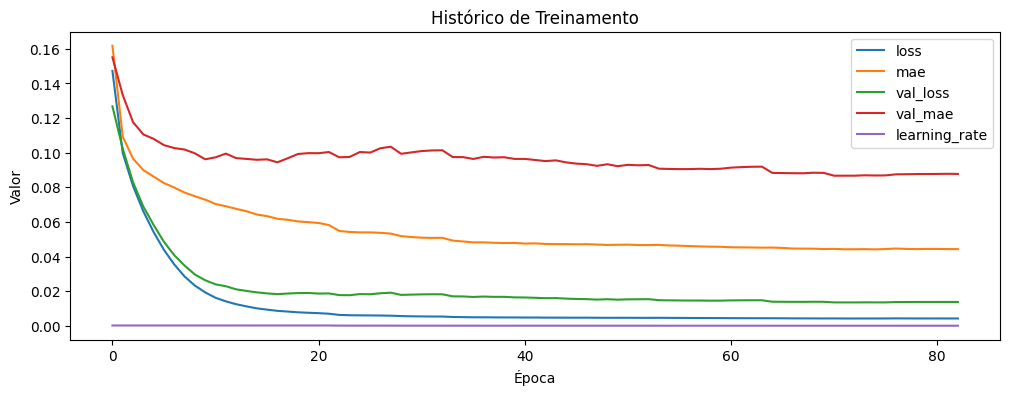

[DIVIDIDO] train: 129,357 linhas
[DIVIDIDO] val: 43,119 linhas
[DIVIDIDO] test: 43,120 linhas


C:\Users\victo\AppData\Local\Temp\ipykernel_26224\2175211169.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cname] = (
C:\Users\victo\AppData\Local\Temp\ipykernel_26224\2175211169.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cname] = (
C:\Users\victo\AppData\Local\Temp\ipykernel_26224\2175211169.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

[SALVO] TFRecords: 3 shard(s) em data\N1B\linear_model
[SALVO] TFRecords: 1 shard(s) em data\N1B\linear_model
[SALVO] TFRecords: 1 shard(s) em data\N1B\linear_model
Pré-processamento linear concluído.


[I 2025-10-25 19:26:13,748] A new study created in memory with name: no-name-b77bed02-55dd-4b9c-8d42-c6c1e3cacde5


Dataset TFRecord carregado para treinamento.


c:\Users\victo\OneDrive\Documentos\TCC\TCC-2025\tfc_venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [ ]:
# Criando modelo para múltiplos níveis

modelos_lineares = {
    "N1": {
        "A":
            linear_pipeline(
                data_dir=os.path.join('data', 'N1A'),
                feature_cols=["country","datetime","quantity_MW"],
                target_cols=["quantity_MW"],
                lag=7*96,
                lead=96,
                value_cols=['quantity_MW'],
                country_list=["ES"]),
        "B":
            linear_pipeline(
                data_dir=os.path.join('data', 'N1B'),
                feature_cols=["country","datetime","quantity_MW"],
                target_cols=["quantity_MW"],
                lag=30*96,
                lead=3*96,
                value_cols=['quantity_MW'],
                country_list=COUNTRY_DOMAINS.keys()),
        "C":
            linear_pipeline(
                data_dir=os.path.join('data', 'N1C'),
                feature_cols=["country","datetime","quantity_MW"],
                target_cols=["quantity_MW"],
                lag=90*96,
                lead=7*96,
                value_cols=['quantity_MW'],
                country_list=COUNTRY_DOMAINS.keys())
    },
    "N2":{
        "A":
            linear_pipeline(
                data_dir=os.path.join('data', 'N2A'),
                feature_cols=["country","datetime","quantity_MW","price_EUR_MWh"],
                target_cols=[ "quantity_MW", "price_EUR_MWh"],
                lag=7*96,
                lead=96,
                value_cols=['quantity_MW',"price_EUR_MWh"],
                country_list=["ES"]),
        "B":
            linear_pipeline(
                data_dir=os.path.join('data', 'N2B'),
                feature_cols=["country","datetime","quantity_MW","price_EUR_MWh"],
                target_cols=[ "quantity_MW", "price_EUR_MWh"],
                lag=30*96,
                lead=3*96,
                value_cols=['quantity_MW',"price_EUR_MWh"],
                country_list=COUNTRY_DOMAINS.keys()),
        "C":
            linear_pipeline(
                data_dir=os.path.join('data', 'N2C'),
                feature_cols=["country","datetime","quantity_MW","price_EUR_MWh"],
                target_cols=[ "quantity_MW", "price_EUR_MWh"],
                lag=90*96,
                lead=7*96,
                value_cols=['quantity_MW',"price_EUR_MWh"],
                country_list=COUNTRY_DOMAINS.keys())
    }
}